In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


In [ ]:
!pip install tensorflow_text
!pip install tensorflow_hub
!pip install tensorflow_addons
!pip install tfds-nightly
import tensorflow_datasets as tfds
import tensorflow_addons as ado
import tensorflow_text as text
import tensorflow_hub as hub

     |████████████████████████████████| 3.4MB 8.3MB/s 
     |████████████████████████████████| 706kB 7.5MB/s 
     |████████████████████████████████| 3.8MB 7.4MB/s 


In [ ]:
#tfds.list_builders()
train,test=tfds.load('goemotions',split=['train','test'])


Dataset goemotions downloaded and prepared to /root/tensorflow_datasets/goemotions/0.1.0. Subsequent calls will reuse this data.


In [ ]:
train=tfds.as_dataframe(train)
test=tfds.as_dataframe(test)
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


In [ ]:
print(train.head(5))

   admiration  amusement  anger  annoyance  ...  relief  remorse sadness  surprise
0       False      False  False      False  ...   False    False   False     False
1        True      False  False      False  ...   False    False   False     False
2       False      False  False      False  ...   False    False    True     False
3       False      False  False      False  ...   False    False   False     False
4       False      False  False      False  ...   False    False   False     False

[5 rows x 29 columns]


In [ ]:
train=train.replace(False,0)
X_train=train['comment_text']
Y_train=train.drop(['comment_text'],axis=1)
Y_train=Y_train.drop(["neutral"],axis=1)

In [ ]:
zef=Y_train.columns.values.tolist()
print(zef)

['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']


In [ ]:
test=test.replace(False,0)
X_test=test['comment_text']
Y_test=test.drop(['comment_text'],axis=1)
Y_test=Y_test.drop(['neutral'],axis=1)

In [ ]:
X_train=X_train.values.tolist()
Y_train=Y_train.values.tolist()
X_test=X_test.values.tolist()
Y_test=Y_test.values.tolist()

In [ ]:
for i in range(len(X_train)):
  X_train[i]=X_train[i].decode("UTF-8")

In [ ]:
for i in range(len(X_test)):
  X_test[i]=X_test[i].decode("UTF-8")

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(Y_train[0]))
print(len(Y_test[0]))

43410
5427
27
27


Preprocessing pipleine

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder=hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")
encoder.trainable=False
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(128,activation='relu')(net)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(64,activation='relu')(net)
net = tf.keras.layers.Dropout(0.2)(net)
net = tf.keras.layers.Dense(27, activation='softmax', name='classifier')(net)
model=tf.keras.Model(text_input,net)


In [ ]:
for layers in model.layers:
  print(layers)

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0031),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )

reduce_lr=keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",factor=0.2,patience=3
)

early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5,restore_best_weights=True
)

In [ ]:
history = model.fit(X_train,Y_train,
    validation_data=(X_test,Y_test),
    epochs=35,callbacks=[reduce_lr,early_stopping],batch_size=256)

Epoch 1/35
170/170 [==============================] - 432s 3s/step - loss: 18.7054 - acc: 0.1511 - val_loss: 213.2775 - val_acc: 0.0464
Epoch 2/35
170/170 [==============================] - 423s 2s/step - loss: 1109.0564 - acc: 0.0731 - val_loss: 7159.3779 - val_acc: 0.0221
Epoch 3/35
170/170 [==============================] - 422s 2s/step - loss: 7127.1358 - acc: 0.0710 - val_loss: 16727.6973 - val_acc: 0.0464
Epoch 4/35
170/170 [==============================] - 421s 2s/step - loss: 19770.8289 - acc: 0.0673 - val_loss: 21626.9785 - val_acc: 0.0155
Epoch 5/35
170/170 [==============================] - 428s 3s/step - loss: 8360.7710 - acc: 0.0780 - val_loss: 2157.0334 - val_acc: 0.0223
Epoch 6/35
170/170 [==============================] - 434s 3s/step - loss: 2927.6703 - acc: 0.0726 - val_loss: 2824.2288 - val_acc: 0.0221


In [ ]:
model.save("bert_encoder")

INFO:tensorflow:Assets written to: bert_encoder/assets


INFO:tensorflow:Assets written to: bert_encoder/assets


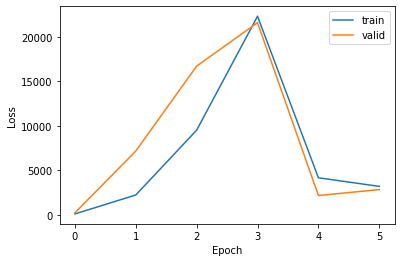

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [ ]:
cp -r bert_encoder /content/gdrive/MyDrive/bert_encoder0